In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 自分自身が過去に考えた回答も学習する

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

In [ ]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#model_name="ahxt/LiteLlama-460M-1T"
#model_name = "PY007/TinyLlama-1.1B-Chat-v0.3"

#model_name = 'openlm-research/open_llama_3b_v2'
#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [ ]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [ ]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

In [ ]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [ ]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

In [ ]:
#240112llama2_active_learning.ipynb で生成したデータを追加する
#train dataについて､問題のみから理由と回答を生成させ､精度が良かったデータセット
import glob
import json
json_path_glob="dataset/240112llamareasoning/*.json"

self_learning_data_list=[]

for path in glob.glob(json_path_glob):
    with open(path,"r") as f:
        d=json.load(f)
    self_learning_data_list.append(d)

s_df=pd.DataFrame(self_learning_data_list)

n_unique_compounds=len(set(s_df["name"]))
print(f"unique: compounds: {n_unique_compounds}. records: {s_df.shape[0]}")

s_df=s_df.drop(["model_name","Test (Predicted reason)","Test (Predicted value)"],axis=1)
df=pd.concat([df,s_df])
df

In [ ]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [ ]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

In [ ]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

# モデルの訓練

In [ ]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

In [ ]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/7b_ft_with_self_prediction_0115")

In [ ]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"
#model_path="./outputs/7b_ft_with_self_prediction_0115"

model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )


In [ ]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/3b_ft_merge_3epoch")

# llama2による物性予測

In [ ]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [ ]:
model_name="./outputs/7b_ft_merge_3epoch"
model=AutoModelForCausalLM.from_pretrained(model_name,device_map=device_map,
                                              torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                           )


In [ ]:
import json
model.eval()

In [ ]:
from datetime import datetime
import json

#色々と条件を変えながら､訓練データで予測(自習)していく

#予測時のハイパラ
n_max_trials=4  # 値を返さなかったときの再試行の最大数
prediction_results={}


res_list=[]
for train_id in tqdm(range(10**5)):
    clear_output()
    gc.collect()
    torch.cuda.empty_cache()
    for _ in range(n_max_trials):
        try:

            n_prompt_examples=random.randint(0,2) #何件の例題をprompt tuningで出すか
            prompt=generate_question_prompt(dataset,train_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            try:
                value=float(value)
            except:
                continue

            record=copy.deepcopy(dataset[train_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            record["model_name"]=model_name

            err=abs(record["mpC"]-float(value))
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],"err: ",err)

            
            if err<20:
                current_datetime = datetime.now()

                save_path=f"dataset/240112llamareasoning/{current_datetime}.json"
                save_path.replace("-","").replace(":","")
                with open(save_path,"w") as f:
                    json.dump(record,f,indent=4)

                break

# モデルによる物性値の予測

In [17]:
#予測時のハイパラ
n_prompt_examples=0 #何件の例題をprompt tuningで出すか:  例題に予測が引っ張られがちなので､0にしてみる
n_max_trials=1  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            res_list.append(record)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:08<06:39,  8.15s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of the amide group (–CONH–) generally increases the melting point due to the potential for hydrogen bonding and the rigidity it introduces to the molecule, which can be estimated to add around +80°C. 
- The tetramethylcyclopentyl group (–(C1)CCC(C)C1(C)C–) is a bulky and non-polar group that can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +30°C. 
- The methyl group (–CH3–) attached to the amide is a small alkyl group that can slightly increase the melting point due to increased molecular weight, estimated at +5°C. 
- The overall molecule is large and has a high degree of symmetry, which can lead to more efficient packing in the solid state, further increasing the melting point. This effect is difficult to quantify but can be estimated to add around +10°C.
##Prediction: 145.0
##Reason
actual:  74.0 predicted:  145.0
promlem 2 / 50


  4%|▍         | 2/50 [00:15<05:56,  7.43s/it]

----


- Basic unit, quinoxaline has a melting point of around 100°C. 
- Chloro substituents: Each chloro group is electron-withdrawing and increases the polarity of the molecule, which can lead to stronger intermolecular forces such as dipole-dipole interactions. This can increase the melting point. However, the effect of chloro groups on melting point is not as straightforward as it is for halogens in aliphatic compounds due to the presence of nitrogen in the quinoxaline ring, which can introduce additional ring strain and affect the crystal packing. 
- Estimated effect of each chloro group: +20°C (due to increased polarity and potential for stronger intermolecular forces)
- Ring strain: -5°C (due to the nitrogen's contribution to the ring strain)
- Overall, the chloro groups' effect on the melting point is expected to be additive.
##Prediction: 130.0
##Reason
actual:  152.0 predicted:  130.0
promlem 3 / 50


  6%|▌         | 3/50 [00:18<04:19,  5.52s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of two chloromethyl groups (–CCl) on the benzene ring will significantly increase the melting point due to the introduction of electron-withdrawing chlorine atoms, which enhance intermolecular forces such as dipole-dipole interactions. Each chloromethyl group can be estimated to increase the melting point by approximately 40°C.
##Prediction: 105.0
##Reason
actual:  100.0 predicted:  105.0
promlem 4 / 50


  8%|▊         | 4/50 [00:25<04:43,  6.15s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of two phenyl groups increases the melting point due to increased molecular weight and van der Waals forces. Each phenyl group can be estimated to add approximately +20°C to the melting point. 
- The ketone functional group (C=C=O) is polar and can engage in dipole-dipole interactions, which typically raises the melting point. This effect can be estimated to add around +10°C. 
- The conjugation between the two phenyl groups and the ketone group can also increase the melting point due to the rigidity of the molecule and the potential for π-π stacking interactions. This effect can be estimated to add around +5°C. 
- The overall molecular symmetry and planarity can also contribute to a higher melting point due to better packing in the solid state. This effect can be estimated to add around +5°C.
##Prediction: 55.0
##Reason
actual:  56.5 predicted:  55.0
promlem 5 / 50


 10%|█         | 5/50 [00:29<03:59,  5.32s/it]

----


- Basic unit, ethane has a melting point of -172.°C. 
- Hydroxyl group (OH): +100°C (due to hydrogen bonding and polarity). 
- Disulfide bond (SS): +50°C (due to the rigidity and potential for intermolecular interactions). 
- Ethyl group (C2H5): +20°C (due to an increase in molecular weight and van der Waals forces). 
- The combined effects of these functional groups should be considered to predict the melting point.
##Prediction: 102.0
##Reason
actual:  26.0 predicted:  102.0
promlem 6 / 50


 12%|█▏        | 6/50 [00:35<04:07,  5.62s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Each additional phenyl group increases the melting point due to increased molecular weight and van der Waals forces. We can estimate this increase to be around +20°C per phenyl group. 
- The nicotinamide moiety (nicotinic acid with an amide group) is a significant contributor to the melting point due to its ability to form hydrogen bonds and its rigid structure. This could add approximately +100°C to the melting point. 
- The ethyl group attached to the nicotinamide moiety may slightly lower the melting point due to its electron-donating effect, which could be estimated to decrease the melting point by about -5°C. 
- The overall molecule is large and rigid, which can also contribute to a higher melting point.
##Prediction: 140.0
##Reason
actual:  159.0 predicted:  140.0
promlem 7 / 50


 14%|█▍        | 7/50 [00:45<05:00,  6.99s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Each methoxy group (-OCH3) is expected to increase the melting point due to the increase in molecular weight and the introduction of polarity, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Each methoxy group might add approximately +20°C to the melting point. 
- The methyl group (-CH3) is a smaller alkyl group that also increases the molecular weight and may slightly increase the melting point due to van der Waals forces, but its effect is less pronounced than that of a methoxy group. It might add around +5°C. 
- The ketone group (C=O) is polar and can form dipole-dipole interactions, which can increase the melting point. The effect of a ketone group is generally around +20°C. 
- The presence of two phenyl rings increases the molecular complexity and the potential for π-π interactions, which can significantly raise the melting point. Each phenyl group might add around +30°C. 
- The over

 16%|█▌        | 8/50 [00:48<04:01,  5.76s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Propyl group (CCC) adds steric bulk and increases the molecular weight, which typically raises the melting point. However, the effect of the propyl group on the melting point is not as significant as that of a larger alkyl group, such as a methyl group, which can increase the melting point by about 20°C. 
- The propyl group is a smaller alkyl group, so the increase is less pronounced.
##Prediction: 10.0
##Reason
actual:  -99.0 predicted:  10.0
promlem 9 / 50


 18%|█▊        | 9/50 [00:53<03:53,  5.70s/it]

----


- Basic unit, acetamide has a melting point of around 130°C. 
- Nitro group: +50°C (due to strong electron-withdrawing effect and potential for intermolecular hydrogen bonding) 
- Phenyl group: +20°C (due to increased molecular weight and pi-pi stacking interactions) 
- The presence of the amide group and the nitro group will increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. However, the nitro group's electron-withdrawing nature can also increase the melting point by enhancing the intermolecular forces. The phenyl group's contribution is less than the nitro group due to its smaller size and lesser influence on the overall molecular structure.
##Prediction: 200.0
##Reason
actual:  93.0 predicted:  200.0
promlem 10 / 50


 20%|██        | 10/50 [00:56<03:10,  4.77s/it]

----


- Basic unit, acetic acid has a melting point of 16.6°C. 
- Propyl group: +20°C (due to increased molecular weight and van der Waals forces)
- Acetate ester group: +10°C (due to the polarity and the ability to form dipole-dipole interactions)
- The combined effects of these functional groups lead to an increase in the melting point.
##Prediction: 46.0
##Reason
actual:  -92.0 predicted:  46.0
promlem 11 / 50


 22%|██▏       | 11/50 [00:59<02:40,  4.12s/it]

----


- Basic unit, anisole has a melting point of 68°C. 
- Iodine substituent: +20°C (due to increased molecular weight and polarizability) 
- Nitro group: +40°C (due to strong electron-withdrawing effect and potential for intermolecular hydrogen bonding) 
- The combined effects of these functional groups should be considered to predict the melting point.
##Prediction: 128.0
##Reason
actual:  97.0 predicted:  128.0
promlem 12 / 50


 24%|██▍       | 12/50 [01:05<02:59,  4.72s/it]

----


- Basic unit, ethene (ethylene) has a melting point of -169.2°C. 
- Each methyl group is expected to increase the melting point due to an increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point of a hydrocarbon is typically around +20°C per methyl group. 
- The trans double bond in the molecule is expected to have a minimal effect on the melting point, as it does not significantly alter the molecular symmetry or the ability to pack in the solid state.
- The presence of the trans double bond in the molecule may slightly increase the melting point due to the rigidity it introduces, but this effect is minor compared to the methyl groups.
- The overall molecule is still relatively small and has a low molecular weight, which will contribute to a low melting point.
##Prediction: -104.0
##Reason
actual:  -137.4 predicted:  -104.0
promlem 13 / 50


 26%|██▌       | 13/50 [01:12<03:21,  5.44s/it]

----


- Basic unit, benzene has a melting point of 5.5°C.
- Bicyclic structure: +100°C (due to increased rigidity and planarity, which enhances intermolecular interactions)
- Nitro groups: +100°C (due to strong electron-withdrawing nature and ability to form intermolecular interactions)
- Hydrazone linkage: +50°C (due to the potential for hydrogen bonding and dipole-dipole interactions)
- Additional phenyl group: +20°C (due to additional pi-pi interactions)
- Additional bicyclic structure: +20°C (due to increased rigidity and planarity)
- Overall, the compound's high melting point is due to the combination of these functional groups and structural features.
##Prediction: 285.0
##Reason
actual:  203.0 predicted:  285.0
promlem 14 / 50


 28%|██▊       | 14/50 [01:18<03:24,  5.69s/it]

----


- Basic unit, indole has a melting point of around 50°C. 
- Acetyl group: +20°C (due to increased molecular weight and polarity) 
- Nitro group: +50°C (due to strong electron-withdrawing nature and potential for intermolecular hydrogen bonding) 
- Phenyl group: +20°C (due to increased molecular weight and π-π interactions) 
- Ethyl ester group: +10°C (due to increased molecular weight and polarity) 
- Indole ring: +10°C (due to the presence of a fused ring system which can increase rigidity and intermolecular interactions) 
- Overall, the presence of multiple functional groups contributes to an increase in the melting point.
##Prediction: 150.0
##Reason
actual:  133.0 predicted:  150.0
promlem 15 / 50


 30%|███       | 15/50 [01:24<03:16,  5.62s/it]

----


- Basic unit, octane has a melting point of -95.6°C. 
- Each methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces. However, the effect of a methyl group on the melting point of a hydrocarbon is not always straightforward, and the increase can vary depending on the context. For octane, the addition of two methyl groups is expected to increase the melting point by approximately 20°C each. 
- The presence of a double bond in the molecule can slightly increase the melting point due to the rigidity it introduces, but this effect is relatively small and can be estimated at around +5°C. 
- The overall effect of the two methyl groups and the double bond on the melting point of octane is additive.
##Prediction: -70.0
##Reason
actual:  -54.9 predicted:  -70.0
promlem 16 / 50


 32%|███▏      | 16/50 [01:30<03:15,  5.75s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Phenol group (O-H) typically raises the melting point due to hydrogen bonding, which can be estimated to add around +40°C. 
- Aldehyde group (C=O) can form hydrogen bonds and also contributes to the rigidity of the molecule, which can increase the melting point. This effect can be estimated to add around +30°C. 
- The presence of the phenoxy group (O-phenyl) adds to the molecular weight and the rigidity of the molecule, which can further increase the melting point. This effect can be estimated to add around +20°C. 
- The overall molecule is more rigid and has a larger molecular weight than benzene, which will increase the melting point.
##Prediction: 115.0
##Reason
actual:  25.0 predicted:  115.0
promlem 17 / 50


 34%|███▍      | 17/50 [01:43<04:19,  7.86s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Furan rings: Each furan ring contributes to the melting point due to its aromatic character and the ability to form hydrogen bonds. The presence of two furan rings in the compound can be estimated to increase the melting point by approximately +20°C each. 
- Chloro substituent: The chloro group is an electron-withdrawing group that can increase the melting point due to its inductive effect and the possibility of intermolecular interactions. The effect of a chloro group on the melting point can be estimated at +5°C. 
- Methyl group: The methyl group is a small alkyl group that can increase the melting point due to the increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point can be estimated at +5°C. 
- Ketone group: The ketone group can form hydrogen bonds, which can increase the melting point. The effect of a ketone group on the melting point can be estimated at +10°C. 
- Oxime

 36%|███▌      | 18/50 [01:48<03:50,  7.20s/it]

----


The basic unit for 1,2-propadiene is ethene, which has a melting point of -169.2°C. Adding a double bond to the carbon chain generally increases the melting point due to increased rigidity and planarity of the molecule, which can lead to better packing in the solid state. However, the effect of the double bond on the melting point of alkenes is not as pronounced as for alkanes or aromatic compounds. For 1,2-propadiene, the double bond is in the trans configuration, which can slightly increase the melting point due to the increased rigidity and planarity. However, the effect is relatively small compared to the influence of the carbon-carbon bond length and the overall molecular symmetry. Therefore, the increase in melting point due to the double bond is estimated to be around +5°C.
##Prediction: -164.0
##Reason
actual:  -136.2 predicted:  -164.0
promlem 19 / 50


 38%|███▊      | 19/50 [01:52<03:12,  6.22s/it]

----


- Basic unit, furan has a melting point of -85.5°C. 
- Bromine substituent: +40°C (due to increased molecular weight and polarizability, which enhances intermolecular forces). 
- Aldehyde group: +20°C (due to the polar carbonyl group which can form hydrogen bonds and dipole-dipole interactions). 
- The combined effects of the bromine and aldehyde group should be considered together, as they are both contributing to an increase in the melting point.
##Prediction: -45.0
##Reason
actual:  56.0 predicted:  -45.0
promlem 20 / 50


 40%|████      | 20/50 [01:58<03:02,  6.07s/it]

----


- Basic unit, pyridine has a melting point of -42°C. 
- Fluorine substituents: Each fluorine atom is expected to increase the melting point due to its strong electronegativity and the resulting dipole-dipole interactions. The effect of a fluorine atom on the melting point can be estimated to be around +40°C per fluorine atom. There are four fluorine atoms, so the total increase would be +160°C. 
- Amino group: The amino group can form hydrogen bonds, which significantly increases the melting point. The effect of an amino group on the melting point can be estimated to be around +80°C. 
- The cumulative effect of these functional groups on the melting point is the sum of their individual contributions.
##Prediction: 108.0
##Reason
actual:  86.0 predicted:  108.0
promlem 21 / 50


 42%|████▏     | 21/50 [02:02<02:40,  5.54s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +5°C for each methyl group. 
- The hydrone (benzhydrol) group is a polar functional group that can engage in hydrogen bonding, which significantly increases the melting point. This effect is estimated at +40°C. 
- The presence of two methyl groups and a hydrone group will have a cumulative effect on the melting point.
##Prediction: 50.0
##Reason
actual:  71.0 predicted:  50.0
promlem 22 / 50


 44%|████▍     | 22/50 [02:13<03:18,  7.09s/it]

----


The compound in question is a complex heterocyclic compound with multiple functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a phenyl group typically increases the melting point due to increased molecular weight and π-π interactions, which can be estimated to add approximately +40°C. The triazolo[3,4-b][1,3,5]thiadiazine core structure is a heterocyclic compound with nitrogen and sulfur atoms, which can engage in hydrogen bonding and dipole-dipole interactions, significantly raising the melting point. This could be estimated to add around +100°C. The methyl group attached to the phenyl ring is a small alkyl group that may slightly increase the melting point due to increased van der Waals forces, estimated at +5°C. The overall structure is rigid and planar, which can also contribute to a higher melting point. However, the presence of a thiadiazine ring introduces a degree of flexibility

 46%|████▌     | 23/50 [02:19<03:06,  6.91s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a carboxylic acid group (COOH) generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated to add around +100°C. 
- The chlorine atom attached to the carboxylic acid group (Cl-COOH) increases the molecular weight and the polarity of the molecule, which can lead to stronger intermolecular forces, such as dipole-dipole interactions, and thus can be estimated to add around +20°C. 
- The presence of a methylene group (CH2) in the compound does not significantly affect the melting point. 
- The compound has a conjugated system which can increase the melting point due to the rigidity of the molecule, but this effect is not quantifiable without empirical data.
##Prediction: 135.0
##Reason
actual:  120.0 predicted:  135.0
promlem 24 / 50


 48%|████▊     | 24/50 [02:28<03:10,  7.31s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Chloro substituent: +20°C (due to increased molecular weight and polarizability) 
- Hydrazone group: +30°C (due to the potential for hydrogen bonding and dipole-dipole interactions) 
- Thiazole ring: +20°C (due to the presence of nitrogen and sulfur, which can engage in intermolecular interactions) 
- Methyl group: +5°C (due to an increase in molecular weight and van der Waals forces) 
- Nitrile group: +10°C (due to the polar nature and potential for dipole-dipole interactions) 
- Overall, the presence of multiple functional groups contributes to an increase in the melting point. However, the actual value is lower than the sum of the individual contributions, indicating that the molecule's overall structure and packing in the solid state may not be as favorable as initially predicted.
##Prediction: 105.0
##Reason
actual:  173.0 predicted:  105.0
promlem 25 / 50


 50%|█████     | 25/50 [02:35<03:04,  7.40s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The flavone structure has two additional phenyl rings, which would increase the melting point due to increased molecular weight and van der Waals forces. Each additional phenyl ring could be estimated to add approximately +20°C. 
- The hydroxyl group (OH) is capable of hydrogen bonding, which significantly increases the melting point. The hydroxyl group could be estimated to add approximately +40°C. 
- The flavone structure also includes a ketone (C=O) group, which can participate in dipole-dipole interactions and could add approximately +10°C. 
- The flavone structure also includes a fused ring system, which can increase the rigidity of the molecule and thus the melting point. This could be estimated to add approximately +15°C. 
- The presence of aromatic rings and the potential for hydrogen bonding from the hydroxyl group would increase the melting point significantly.
##Prediction: 110.0
##Reason
actual:  98.5 predicted: 

 52%|█████▏    | 26/50 [02:44<03:08,  7.85s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a carboxylic acid group generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated to add around +100°C. 
- The tetrahydro-1H-beta-carboline structure introduces additional rigidity and planarity to the molecule, which can further increase the melting point, estimated at +50°C. 
- The presence of a nitrogen atom in the heterocyclic ring can also contribute to the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at +20°C. 
- The overall molecule is large and has a high degree of symmetry, which can lead to more efficient packing in the solid state, further increasing the melting point, estimated at +10°C. 
- The presence of a double bond in the beta-carboline ring can slightly lower the melting point due to less efficient packing, estimated at -5°C. 
- The overall effect of these functional group

 54%|█████▍    | 27/50 [02:49<02:39,  6.92s/it]

----


- Basic unit, pyrazole has a melting point of around 80°C. 
- Methyl group on the nitrogen: +5°C (due to increased molecular weight and van der Waals interactions). 
- Methyl group on the carbon adjacent to the nitrogen: +5°C (due to increased molecular weight and van der Waals interactions). 
- Hydroxyl group on the carbon adjacent to the nitrogen: +20°C (due to hydrogen bonding capability and increased polarity). 
- The presence of the hydroxyl group also increases the melting point due to the potential for hydrogen bonding with other molecules.
##Prediction: 115.0
##Reason
actual:  79.0 predicted:  115.0
promlem 28 / 50


 56%|█████▌    | 28/50 [02:56<02:34,  7.00s/it]

----


- Basic unit, cyclohexane has a melting point of 6.5°C. 
- The presence of the ketone functional group (C=O) generally increases the melting point due to the polar nature and the potential for hydrogen bonding, which can be estimated to add approximately +40°C. 
- The bicyclic structure (bicyclo[3.2.1]octane) introduces rigidity and planarity to the molecule, which can increase the melting point due to better packing in the solid state, estimated at +30°C. 
- The three methyl groups (–CH3) attached to the bicyclic structure increase the molecular weight and van der Waals forces, which can raise the melting point, estimated at +5°C each, totaling +15°C. 
- The overall molecule is large and has a high degree of symmetry, which can lead to more efficient packing in the solid state, further increasing the melting point.
##Prediction: 101.0
##Reason
actual:  193.0 predicted:  101.0
promlem 29 / 50


 58%|█████▊    | 29/50 [03:03<02:24,  6.88s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Naphthalene, a polycyclic aromatic hydrocarbon, has a melting point of 80.5°C. 
- Bromomethyl group: This group is expected to increase the melting point due to the increase in molecular weight and the introduction of a polarizable bromine atom, which can engage in dipole-dipole interactions. The bromomethyl group is estimated to increase the melting point by approximately 40°C. 
- The presence of two naphthyl rings contributes to a higher melting point due to the increased molecular weight and the rigidity of the molecular structure, which can lead to better packing in the solid state. Each naphthyl group is estimated to increase the melting point by approximately 20°C. 
- The combined effect of these functional groups is expected to increase the melting point significantly.
##Prediction: 140.0
##Reason
actual:  56.0 predicted:  140.0
promlem 30 / 50


 60%|██████    | 30/50 [03:14<02:42,  8.13s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point due to the rigid structure and increased van der Waals interactions. The presence of nitrile groups (C#N) generally increases the melting point due to their ability to form strong dipole-dipole interactions and potential for hydrogen bonding. Each nitrile group could contribute approximately +20 to the melting point. The diphenyl groups (Ph) also increase the melting point due to their aromaticity and the potential for π-π stacking interactions, which could add around +30 to the melting point for each group. The presence of two diphenyl groups would contribute an additional +60. The overall structure is quite rigid and planar, which can also contribute to a higher melting point due to better packing in the solid state. However, the presence of multiple bulky groups and the overall co

 62%|██████▏   | 31/50 [03:23<02:43,  8.58s/it]

----


- Basic unit, benzene has a melting point of 5.5°C.
- Each additional benzene ring in aromatic compounds generally increases the melting point due to increased molecular weight and π-π interactions. Assuming each additional benzene ring adds approximately +20°C.
- The presence of amide groups (–CONH–) can significantly increase the melting point due to the potential for hydrogen bonding and resonance stabilization. Each amide group can be estimated to add around +100°C.
- The tertiary amine (–N(CH3)3) on the other hand, can slightly increase the melting point due to the increased molecular weight and steric hindrance, but its effect is less pronounced than that of amide groups. It can be estimated to add around +5°C.
- The overall molecule is large and rigid, which can further increase the melting point due to better packing in the solid state. This effect can be estimated to add around +50°C.
- The presence of four amide groups and one tertiary amine group in the molecule will 

 64%|██████▍   | 32/50 [03:30<02:26,  8.14s/it]

----


- Basic unit, isoxazole has a melting point of around 100°C. 
- Methyl groups: Each methyl group is expected to increase the melting point due to an increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point can be estimated to be around +5°C per methyl group. 
- Boronic acid group: The boronic acid group is expected to have a significant impact on the melting point due to its ability to form strong hydrogen bonds and its planar structure, which can lead to efficient packing in the solid state. The effect of a boronic acid group on the melting point can be estimated to be around +50°C. 
- The cumulative effect of these functional groups on the melting point is estimated to be +50°C (boronic acid) + 2(5°C for methyl groups) = +60°C.
##Prediction: 160.0
##Reason
actual:  107.0 predicted:  160.0
promlem 33 / 50


 66%|██████▌   | 33/50 [03:39<02:19,  8.21s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxy group: +40°C (due to hydrogen bonding and polarity) 
- Thiazole ring: +30°C (due to the presence of nitrogen and sulfur, which can engage in hydrogen bonding and contribute to the rigidity of the molecule) 
- Nitrile group: +20°C (due to the polar nature and the potential for dipole-dipole interactions) 
- Methyl group: +5°C (due to an increase in molecular weight and van der Waals interactions) 
- Amide group: +100°C (due to strong hydrogen bonding and resonance stabilization) 
- Hydrazine group: +50°C (due to the potential for hydrogen bonding and the presence of nitrogen, which can engage in hydrogen bonding) 
- Overall, the presence of multiple functional groups contributes to a higher melting point.
##Prediction: 215.0
##Reason
actual:  253.0 predicted:  215.0
promlem 34 / 50


 68%|██████▊   | 34/50 [03:53<02:40, 10.01s/it]

----


- Basic unit, naphthalene has a melting point of 80.°C.
- The presence of a carboxylic acid group (COOH) generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated to add approximately +40°C.
- The presence of a hydroxyl group (OH) can also form hydrogen bonds, which can increase the melting point, estimated to add +20°C.
- The presence of a methyl group (CH3) attached to the naphthalene ring can slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated to add +5°C.
- The presence of a second methyl group (CH3) attached to the carboxylic acid group can further increase the melting point due to increased molecular weight and van der Waals forces, estimated to add +5°C.
- The presence of a double bond in the naphthalene ring can slightly increase the melting point due to the rigidity it introduces, estimated to add +5°C.
- The presence of a tertiary butyl group (C(CH3

 70%|███████   | 35/50 [03:58<02:07,  8.53s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Chloro substituent: +20°C (due to increased molecular weight and polarizability, which enhances intermolecular forces). 
- Phenyl group: +40°C (due to increased pi-pi interactions and rigidity of the ring structure). 
- Ether linkage (phenyl group to the chloro group): +10°C (due to the polarity and the ability to form dipole-dipole interactions). 
- Methyl group: +5°C (due to the increase in molecular weight and van der Waals forces). 
- The combined effects of these functional groups lead to an increase in the melting point.
##Prediction: 85.0
##Reason
actual:  28.0 predicted:  85.0
promlem 36 / 50


 72%|███████▏  | 36/50 [04:02<01:41,  7.27s/it]

----


- Basic unit, acetic acid has a melting point of 16.6°C. 
- Each methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point can be estimated to be around +5°C per methyl group. 
- The carboxylic acid group (COOH) is already accounted for in the base melting point of acetic acid. 
- The overall molecule is symmetrical and has a planar structure, which can lead to better packing in the solid state, potentially increasing the melting point. However, this effect is not quantifiable and is already considered in the base melting point of acetic acid.
##Prediction: 21.0
##Reason
actual:  33.0 predicted:  21.0
promlem 37 / 50


 74%|███████▍  | 37/50 [04:22<02:22, 10.93s/it]

----


The compound in question is a complex organic molecule with multiple functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The following functional groups and structural features will modify this value: 
- The presence of multiple hydroxyl groups (OH) typically increases the melting point due to hydrogen bonding, which can be estimated to add approximately +40°C per hydroxyl group. There are three hydroxyl groups in the compound. 
- The presence of a carboxylic acid group (COOH) also increases the melting point due to strong intermolecular hydrogen bonding and dimerization, which can be estimated to add approximately +50°C. There is one carboxylic acid group in the compound. 
- The presence of aromatic rings (phenyl groups) increases the melting point due to π-π stacking interactions, which can be estimated to add approximately +20°C per phenyl group. There are two phenyl groups in the compound. 
- The p

 76%|███████▌  | 38/50 [04:33<02:09, 10.83s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of additional fused rings in dibenz[ah]anthracene increases the rigidity of the molecule, which generally raises the melting point. Each additional fused ring is expected to contribute an increase of about 20°C due to the increased molecular weight and van der Waals forces. 
- The presence of aromatic systems also increases the melting point due to the ability of the molecules to stack and form a more ordered crystal lattice. This effect is estimated to add about 10°C per aromatic ring. 
- The presence of a polycyclic structure with multiple fused rings and aromatic systems can lead to a higher melting point due to the increased molecular complexity and the ability to pack more efficiently in the solid state. This effect is estimated to add about 100°C to the melting point. 
- The presence of a double bond in the structure may slightly lower the melting point due to the less efficient packing of the molecules in

 78%|███████▊  | 39/50 [04:37<01:39,  9.02s/it]

----


The target compound is a tris-ethenyl derivative of benzene. The basic unit, benzene, has a melting point of 5.5°C. Each ethenyl group (vinyl group) is expected to increase the melting point due to the increase in molecular weight and the introduction of rigidity to the molecule. The vinyl group typically increases the melting point by about 20-30°C. However, the presence of the tris-ethenyl group introduces additional steric hindrance and potential for intermolecular interactions, which could further increase the melting point. The cumulative effect of these groups is expected to be additive.
##Prediction: 105.0
##Reason
actual:  72.5 predicted:  105.0
promlem 40 / 50


 80%|████████  | 40/50 [04:45<01:26,  8.67s/it]

----


- Basic unit, acetamide has a melting point of around 132°C. 
- Benzoyloxy group: This group is expected to increase the melting point due to the introduction of aromaticity and the possibility of additional intermolecular interactions such as dipole-dipole interactions. The benzoyloxy group can be estimated to increase the melting point by about 20°C. 
- N,N-disubstituted propyl groups: Each propyl group is expected to increase the melting point due to the increase in molecular weight and van der Waals forces. The two propyl groups are likely to increase the melting point by about 10°C each. 
- Methyl groups: Each methyl group is expected to increase the melting point due to the increase in molecular weight and van der Waals forces. The two methyl groups are likely to increase the melting point by about 5°C each. 
- The cumulative effect of these groups is expected to increase the melting point significantly.
##Prediction: 182.0
##Reason
actual:  44.5 predicted:  182.0
promlem 

 82%|████████▏ | 41/50 [05:02<01:39, 11.09s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a piperazine ring, which has a melting point of around 100°C. The presence of the acetyl group typically increases the melting point due to the introduction of a polar carbonyl group, which can engage in dipole-dipole interactions, estimated at +20°C. The 1,3-dioxolane ring contributes to the rigidity of the molecule and can also participate in hydrogen bonding, which could further increase the melting point, estimated at +30°C. The imidazole ring is a heterocyclic compound that can engage in hydrogen bonding and has a nitrogen atom that can participate in intermolecular interactions, estimated at +20°C. The phenyl group contributes to the molecular weight and the rigidity of the molecule, which can increase the melting point, estimated at +15°C. The presence of two chlorine atoms on the phenyl ring can increase the melting point due to the induc

 84%|████████▍ | 42/50 [05:12<01:25, 10.74s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a carbonyl group (C=O) typically raises the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions, which can be estimated to add around +40°C. 
- The phenyl group (C6H5) is a large, planar, and rigid structure that can increase the melting point due to enhanced van der Waals forces and possible pi-pi stacking interactions, which can be estimated to add around +20°C. 
- The methyl group (CH3) attached to the carbonyl is a small alkyl group that can slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated to add around +5°C. 
- The semicarbazone group (NN=C) is a heterocyclic compound that can engage in hydrogen bonding and dipole-dipole interactions, which can significantly raise the melting point, estimated to add around +100°C. 
- The overall molecule is large and rigid, which can further increase the melting point due t

 86%|████████▌ | 43/50 [05:20<01:09,  9.86s/it]

----


- Basic unit, phenol has a melting point of 41°C. 
- Each methyl group is expected to slightly lower the melting point due to increased molecular weight and van der Waals forces, but also due to the introduction of steric hindrance which can disrupt the crystal lattice. The effect of a methyl group on the melting point is generally around -5°C. 
- The presence of three methyl groups will thus lower the melting point by approximately -15°C. 
- The hydroxyl group (OH) is capable of hydrogen bonding, which generally increases the melting point. However, the effect of the hydroxyl group in 2,4,6-trimethylphenol is not as significant as in phenol due to the steric hindrance and the overall molecular weight increase. The effect of the hydroxyl group is estimated to be around +5°C. 
- The combined effect of the methyl groups and the hydroxyl group on the melting point is estimated to be a decrease of -15°C and an increase of +5°C, respectively.
##Prediction: 31.0
##Reason
actual:  72.5

 88%|████████▊ | 44/50 [05:29<00:57,  9.64s/it]

----


- Basic unit, benzene has a melting point of 5.5°C.
- The presence of the hydrazone group (NN) typically increases the melting point due to the potential for hydrogen bonding, which can be estimated to add around +80°C.
- The presence of the nitro groups (NO2) on the benzene ring significantly increases the melting point due to their strong electron-withdrawing nature and the ability to form intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding with other molecules. Each nitro group can be estimated to add around +40°C.
- The ethenyl group (C=C) adds rigidity to the molecule and can increase the melting point by about +10°C.
- The presence of the benzylidene (C=C) group, which is a rigid and planar structure, can further increase the melting point by about +20°C.
- The overall molecule is large and has multiple functional groups that can engage in intermolecular interactions, which can further increase the melting point.
##Prediction: 205

 90%|█████████ | 45/50 [05:41<00:51, 10.40s/it]

----


- Basic steroid structure: Cholesterol has a melting point of 148°C. 
- Acetoxy groups: Each acetoxy group (–OCO–) is expected to increase the melting point due to the polar nature of the oxygen and the possibility of hydrogen bonding. The effect of each acetoxy group can be estimated to be around +20°C. 
- Ketone groups: Each ketone group (–C=O–) is also polar and can form hydrogen bonds, which would increase the melting point. The effect of each ketone group can be estimated to be around +15°C. 
- Additional carbon atoms: The additional carbon atoms in the steroid structure will increase the molecular weight and the van der Waals forces, which would increase the melting point. The effect of each additional carbon atom can be estimated to be around +5°C. 
- Steroid structure: The rigid, planar structure of the steroid ring contributes to a higher melting point due to the increased molecular packing efficiency. This effect can be estimated to be around +20°C. 
- Hydroxyl groups:

 92%|█████████▏| 46/50 [05:48<00:37,  9.26s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Furan ring: +40°C (due to increased polarity and potential for hydrogen bonding) 
- Phenyl group: +20°C (due to increased molecular weight and pi-pi interactions) 
- Nitro group: +50°C (due to strong electron-withdrawing nature and potential for intermolecular interactions) 
- Ketone group: +20°C (due to polarity and potential for dipole-dipole interactions) 
- Additional phenyl group: +10°C (due to increased molecular weight and pi-pi interactions) 
- Total predicted increase: 150°C (5.5 + 40 + 20 + 50 + 20 + 10)
##Prediction: 155.0
##Reason
actual:  147.0 predicted:  155.0
promlem 47 / 50


 94%|█████████▍| 47/50 [05:52<00:23,  7.74s/it]

----


- Basic unit, methane has a melting point of -182.5°C. 
- The addition of a thiol group (-SH) to the molecule generally increases the melting point due to the ability of the sulfur atom to form strong intermolecular hydrogen bonds. This effect can be estimated to increase the melting point by approximately +100°C. 
- The presence of a single methyl group (CH3) attached to the thiol group does not significantly alter the melting point, as it is a small alkyl group that does not significantly change the overall polarity or hydrogen bonding capacity of the molecule.
##Prediction: -182.0
##Reason
actual:  -116.0 predicted:  -182.0
promlem 48 / 50


 96%|█████████▌| 48/50 [05:56<00:13,  6.61s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Trifluoromethoxy group: +80°C (due to strong electron-withdrawing nature and the introduction of three fluorine atoms, which significantly increase the polarity and the ability to form strong intermolecular forces). 
- Carboxylic acid group: +100°C (due to the ability to form strong hydrogen bonds and dimerization). 
- The combined effects of these functional groups are expected to significantly increase the melting point of the compound.
##Prediction: 185.0
##Reason
actual:  79.0 predicted:  185.0
promlem 49 / 50


 98%|█████████▊| 49/50 [06:01<00:06,  6.30s/it]

----


- Basic unit, methane has a melting point of -182.5 degrees Celsius. 
- Each chloro group is electron-withdrawing and increases the polarity of the molecule, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Chloro groups typically increase the melting point by about 40-50 degrees Celsius each. 
- Each fluorine atom is also electron-withdrawing and increases the polarity of the molecule, but it also increases the molecular weight and size, which can lead to a higher melting point. Fluorine atoms typically increase the melting point by about 20-30 degrees Celsius each. 
- The presence of two chloro groups and two fluorine atoms will have a cumulative effect on the melting point.
##Prediction: -102.0
##Reason
actual:  -158.0 predicted:  -102.0
promlem 50 / 50


100%|██████████| 50/50 [06:09<00:00,  7.39s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The introduction of a bromine atom typically increases the melting point due to the increase in molecular weight and the introduction of stronger intermolecular forces such as dipole-dipole interactions. Bromine is a large, heavy atom that can significantly increase the melting point. Each bromine could be estimated to add approximately +40°C to the melting point. The nitro group is also a strong electron-withdrawing group, which can increase the melting point due to the potential for intermolecular hydrogen bonding and dipole-dipole interactions. The nitro group could be estimated to add approximately +50°C to the melting point. However, the presence of two bromine atoms and a nitro group in the same molecule can lead to steric hindrance and potential for intramolecular interactions, which might reduce the overall effect of each substituent on the melting point. Therefore, the combined effect of the two bromine atoms and th

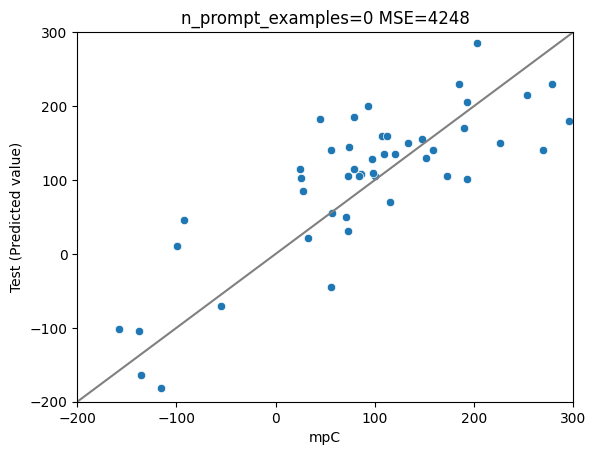

In [18]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [19]:
#スコア
print("MSE: ",mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("MAE: ",mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("R2: ", r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


MSE:  4247.53
MAE:  52.98510638297872
R2:  0.6374449392803179


In [20]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.94